---
execute:
  cache: false
  eval: true
  echo: true
  warning: false
jupyter: python3
---

# Hyperparameter Tuning with PyTorch Lightning and User Data Sets  {#sec-light-user-data-1001}

In [1]:
#| echo: false
#| label: 1001_user_data_imports
import numpy as np
import os
from math import inf
import numpy as np
import warnings
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from spotpython.hyperdict.light_hyper_dict import LightHyperDict
from spotpython.fun.hyperlight import HyperLight
from spotpython.utils.init import (fun_control_init, surrogate_control_init, design_control_init)
from spotpython.utils.eda import print_res_table
from spotpython.hyperparameters.values import set_hyperparameter
from spotpython.spot import Spot
from math import inf
warnings.filterwarnings("ignore")

Seed set to 123


## Creating thr Data 

In [2]:
# epochs = 2000
# seeds = [42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
data = pd.read_csv("/Users/bartz/workspace/schu25a_netgen_gecco/data/data_man_tca88.csv")
data["source_file"] = ["tca88"] * len(data)

In [3]:

from spotpython.data.manydataset import ManyToManyDataset



In [4]:

def load_data(data,
              input_features=['V tot V red [m³/s]'], 
              target= 'PI tot V [-]' ,
              drop = ['Bereich u2red','source_file'],
              group_by='Bereich u2red',
              feature_scaling=None, 
              target_scaling=None, 
              create_dataset=True, 
              dataset_type='many_to_many'):

    if feature_scaling is not None:
        data[input_features] = feature_scaling.fit_transform(data[input_features])
    
    if target_scaling is not None:
        data[target] = target_scaling.fit_transform(data[target])    
    
    if create_dataset == False:
        return data
    else:
        groups = []
        groups_name = []
        data_groups = data.groupby(group_by)

    for name, group in data_groups:
        groups.append(group)
        groups_name.append(name)
    
    if dataset_type == 'many_to_many':
        return ManyToManyDataset(groups, target=target, drop=drop), data
    elif dataset_type == "many_to_one":
        return ManyToOneDataset(groups, target=target, drop=drop), data
kennlinienfelder = data.groupby("source_file")
pred_dict = {}

seeds = [42]
for kennlinienfeld in kennlinienfelder:
    print(f"kennlinienfeld: {kennlinienfeld[0]}")
    data_name = kennlinienfeld[0]
    print(data_name)
    ds, data = ds, _ = load_data(kennlinienfeld[1], 
                                input_features=['PI tot V [-]' ], 
                                target='V tot V red [m³/s]',
                                drop = ['source_file', "Bereich u2red"],
                                group_by="Bereich u2red",
                                # feature_scaling=MinMaxScaler()
                                )
    
    pred_dict[data_name] = {}

    for seed in seeds:
        print(f"seed: {seed}")
        # seed_everything(seed)
        g = torch.Generator()
        g.manual_seed(seed)
        
        pred_dict[data_name][seed] = {}
        pred_dict[data_name][seed]['x'] = []
        pred_dict[data_name][seed]['y_hat'] = []
        pred_dict[data_name][seed]['y'] = []
        pred_dict[data_name][seed]['mape'] = []
        pred_dict[data_name][seed]['rmse'] = []
        
        # Create indices for the split
        indices = list(range(len(ds)))        
        for i in indices:
            test_indices = [indices[i]]
            train_indices = [index for index in indices if index != test_indices[0]]
            
            train_dataset = torch.utils.data.Subset(ds, train_indices)
            test_dataset = torch.utils.data.Subset(ds, test_indices)

kennlinienfeld: tca88
tca88
seed: 42


## Preparing the spotpyhon Run

In [5]:
fun_control=fun_control_init(
    penalty_NA=200,
    ocba_delta=1,
    TENSORBOARD_CLEAN=False,
    tensorboard_log=False,
    accelerator="cpu",
    collate_fn_name="PadSequenceManyToMany",
    show_config=True,
    verbosity=1,
    save_experiment=True,
    save_result=True,
    PREFIX="1003",
    fun_evals=inf,
    fun_repeats=2,
    max_time=1,
    data_full_train = train_dataset,
    data_val=test_dataset,
    data_test=test_dataset,
    shuffle_train=False,
    shuffle_val=False,    
    core_model_name="light.regression.ManyToManyRNNRegressor",
    hyperdict=LightHyperDict,
    log_level=50,
    _L_in=1,
    _L_out=1)

# set_hyperparameter(fun_control, "optimizer", [ "Adadelta", "Adam", "Adamax"])
set_hyperparameter(fun_control, "rnn_units", [6, 12])
set_hyperparameter(fun_control, "fc_units", [6, 12])
set_hyperparameter(fun_control, "epochs", [6 , 8])
set_hyperparameter(fun_control, "batch_size", [1, 3])
set_hyperparameter(fun_control, "dropout_prob", [0.0, 0.025])
set_hyperparameter(fun_control, "patience", [2, 5])
set_hyperparameter(fun_control, "lr_mult", [0.1, 20.0])

design_control = design_control_init(init_size=5, repeats=2)

surrogate_control = surrogate_control_init(log_level=50, noise=True)

fun = HyperLight().fun

spot_tuner = Spot(fun=fun,fun_control=fun_control, design_control=design_control, surrogate_control=surrogate_control)

Seed set to 123


module_name: light
submodule_name: regression
model_name: ManyToManyRNNRegressor
No tensorboard log created.
Experiment saved to 1003_exp.pkl


In [6]:
from spotpython.utils.file import load_and_run_spot_python_experiment
from spotpython.data.manydataset import ManyToManyDataset
load_and_run_spot_python_experiment(filename="1003_exp.pkl")

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 16.8 M | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
16.8 M    Trainable params
0         Non-trainable params
16.8 M    Total params
67.174    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Loaded experiment from 1003_exp.pkl

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.01038327500986472,
 'epochs': 128,
 'fc_units': 2048,
 'lr_mult': 10.939233896767515,
 'optimizer': 'Adamax',
 'patience': 4,
 'rnn_units': 2048}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      10616.306640625      │
│         val_loss          │      10616.306640625      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 16.8 M | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
16.8 M    Trainable params
0         Non-trainable params
16.8 M    Total params
67.174    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 10616.306640625, 'hp_metric': 10616.306640625}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.01038327500986472,
 'epochs': 128,
 'fc_units': 2048,
 'lr_mult': 10.939233896767515,
 'optimizer': 'Adamax',
 'patience': 4,
 'rnn_units': 2048}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     3119.399658203125     │
│         val_loss          │     3119.399658203125     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 25.2 K | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
25.2 K    Trainable params
0         Non-trainable params
25.2 K    Total params
0.101     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3119.399658203125, 'hp_metric': 3119.399658203125}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 4,
 'dropout_prob': 0.001850298977051596,
 'epochs': 256,
 'fc_units': 128,
 'lr_mult': 4.368919111069834,
 'optimizer': 'Adagrad',
 'patience': 8,
 'rnn_units': 64}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.33435946702957153    │
│         val_loss          │    0.33435946702957153    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 25.2 K | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
25.2 K    Trainable params
0         Non-trainable params
25.2 K    Total params
0.101     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.33435946702957153, 'hp_metric': 0.33435946702957153}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 4,
 'dropout_prob': 0.001850298977051596,
 'epochs': 256,
 'fc_units': 128,
 'lr_mult': 4.368919111069834,
 'optimizer': 'Adagrad',
 'patience': 8,
 'rnn_units': 64}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.7515982985496521     │
│         val_loss          │    0.7515982985496521     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 2.6 M  | train | [[8, 10, 1], [8]] | [8, 10, 1]
----------------------------------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.512    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.7515982985496521, 'hp_metric': 0.7515982985496521}

In fun(): config:
{'act_fn': Swish(),
 'batch_size': 8,
 'dropout_prob': 0.019078310062857602,
 'epochs': 64,
 'fc_units': 256,
 'lr_mult': 19.940718231294277,
 'optimizer': 'Rprop',
 'patience': 32,
 'rnn_units': 1024}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │        911783.3125        │
│         val_loss          │        911783.3125        │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 2.6 M  | train | [[8, 10, 1], [8]] | [8, 10, 1]
----------------------------------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.512    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 911783.3125, 'hp_metric': 911783.3125}

In fun(): config:
{'act_fn': Swish(),
 'batch_size': 8,
 'dropout_prob': 0.019078310062857602,
 'epochs': 64,
 'fc_units': 256,
 'lr_mult': 19.940718231294277,
 'optimizer': 'Rprop',
 'patience': 32,
 'rnn_units': 1024}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │         38922.625         │
│         val_loss          │         38922.625         │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 790 K  | train | [[2, 10, 1], [2]] | [2, 10, 1]
----------------------------------------------------------------------------------
790 K     Trainable params
0         Non-trainable params
790 K     Total params
3.160     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 38922.625, 'hp_metric': 38922.625}

In fun(): config:
{'act_fn': Sigmoid(),
 'batch_size': 2,
 'dropout_prob': 0.005669362846308786,
 'epochs': 128,
 'fc_units': 256,
 'lr_mult': 13.111607293242407,
 'optimizer': 'RAdam',
 'patience': 16,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.5055814981460571     │
│         val_loss          │    0.5055814981460571     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 790 K  | train | [[2, 10, 1], [2]] | [2, 10, 1]
----------------------------------------------------------------------------------
790 K     Trainable params
0         Non-trainable params
790 K     Total params
3.160     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.5055814981460571, 'hp_metric': 0.5055814981460571}

In fun(): config:
{'act_fn': Sigmoid(),
 'batch_size': 2,
 'dropout_prob': 0.005669362846308786,
 'epochs': 128,
 'fc_units': 256,
 'lr_mult': 13.111607293242407,
 'optimizer': 'RAdam',
 'patience': 16,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.5539644956588745     │
│         val_loss          │    0.5539644956588745     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 561 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
561 K     Trainable params
0         Non-trainable params
561 K     Total params
2.248     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.5539644956588745, 'hp_metric': 0.5539644956588745}

In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 0.023810468001851916,
 'epochs': 128,
 'fc_units': 2048,
 'lr_mult': 1.0354446885074793,
 'optimizer': 'AdamW',
 'patience': 16,
 'rnn_units': 128}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.0475609228014946     │
│         val_loss          │    0.0475609228014946     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 561 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
561 K     Trainable params
0         Non-trainable params
561 K     Total params
2.248     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.0475609228014946, 'hp_metric': 0.0475609228014946}

In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 0.023810468001851916,
 'epochs': 128,
 'fc_units': 2048,
 'lr_mult': 1.0354446885074793,
 'optimizer': 'AdamW',
 'patience': 16,
 'rnn_units': 128}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │   0.049783628433942795    │
│         val_loss          │   0.049783628433942795    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 658 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
658 K     Trainable params
0         Non-trainable params
658 K     Total params
2.636     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.049783628433942795, 'hp_metric': 0.049783628433942795}

------ Starting optimization on the Surrogate for the given Budget ------


In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.012273328198465362,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 5.094028482512639,
 'optimizer': 'AdamW',
 'patience': 8,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     6.470658302307129     │
│         val_loss          │     6.470658302307129     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 658 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
658 K     Trainable params
0         Non-trainable params
658 K     Total params
2.636     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 6.470658302307129, 'hp_metric': 6.470658302307129}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.012273328198465362,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 5.094028482512639,
 'optimizer': 'AdamW',
 'patience': 8,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.6932985782623291     │
│         val_loss          │    0.6932985782623291     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 0.6932985782623291, 'hp_metric': 0.6932985782623291}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [----------] 1.04% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 1.6 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.312     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.013449887805487422,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 7.2179743740345215,
 'optimizer': 'Adamax',
 'patience': 8,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     9.899867057800293     │
│         val_loss          │     9.899867057800293     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 1.6 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.312     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 9.899867057800293, 'hp_metric': 9.899867057800293}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.013449887805487422,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 7.2179743740345215,
 'optimizer': 'Adamax',
 'patience': 8,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    14.816116333007812     │
│         val_loss          │    14.816116333007812     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 14.816116333007812, 'hp_metric': 14.816116333007812}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [----------] 3.37% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 1.6 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.312     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.013520427303036627,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 7.170035421214262,
 'optimizer': 'AdamW',
 'patience': 8,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    1.6531312465667725     │
│         val_loss          │    1.6531312465667725     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 1.6 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.312     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 1.6531312465667725, 'hp_metric': 1.6531312465667725}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.013520427303036627,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 7.170035421214262,
 'optimizer': 'AdamW',
 'patience': 8,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    4.8385186195373535     │
│         val_loss          │    4.8385186195373535     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 4.8385186195373535, 'hp_metric': 4.8385186195373535}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [----------] 4.83% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 1.6 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.312     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.013571661621473854,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 7.1354604470268965,
 'optimizer': 'SparseAdam',
 'patience': 8,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    27.674213409423828     │
│         val_loss          │    27.674213409423828     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 1.6 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.312     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 27.674213409423828, 'hp_metric': 27.674213409423828}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.013571661621473854,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 7.1354604470268965,
 'optimizer': 'SparseAdam',
 'patience': 8,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    26.140949249267578     │
│         val_loss          │    26.140949249267578     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 26.140949249267578, 'hp_metric': 26.140949249267578}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [#---------] 5.20% 

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.01365057260779234,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 7.085964680697487,
 'optimizer': 'SparseAdam',
 'patience': 8,
 'rnn_units': 512}


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 1.6 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.312     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    26.578359603881836     │
│         val_loss          │    26.578359603881836     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 1.6 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.312     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 26.578359603881836, 'hp_metric': 26.578359603881836}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.01365057260779234,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 7.085964680697487,
 'optimizer': 'SparseAdam',
 'patience': 8,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     26.77334213256836     │
│         val_loss          │     26.77334213256836     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 26.77334213256836, 'hp_metric': 26.77334213256836}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [#---------] 5.64% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 1.6 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.312     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.013733591314270845,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 7.036337697398899,
 'optimizer': 'SparseAdam',
 'patience': 8,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     26.71097183227539     │
│         val_loss          │     26.71097183227539     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 1.6 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.312     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 26.71097183227539, 'hp_metric': 26.71097183227539}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.013733591314270845,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 7.036337697398899,
 'optimizer': 'SparseAdam',
 'patience': 8,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    27.333084106445312     │
│         val_loss          │    27.333084106445312     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 27.333084106445312, 'hp_metric': 27.333084106445312}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [#---------] 6.13% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 1.6 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.312     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.013805971349994084,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 6.994365492385653,
 'optimizer': 'SparseAdam',
 'patience': 8,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    26.900768280029297     │
│         val_loss          │    26.900768280029297     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 1.6 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.312     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 26.900768280029297, 'hp_metric': 26.900768280029297}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.013805971349994084,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 6.994365492385653,
 'optimizer': 'SparseAdam',
 'patience': 8,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    26.584407806396484     │
│         val_loss          │    26.584407806396484     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 26.584407806396484, 'hp_metric': 26.584407806396484}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [#---------] 6.60% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 1.6 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.312     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.013874693962472998,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 6.958792148009655,
 'optimizer': 'SparseAdam',
 'patience': 8,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    26.454830169677734     │
│         val_loss          │    26.454830169677734     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 1.6 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.312     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 26.454830169677734, 'hp_metric': 26.454830169677734}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.013874693962472998,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 6.958792148009655,
 'optimizer': 'SparseAdam',
 'patience': 8,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    27.263885498046875     │
│         val_loss          │    27.263885498046875     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 27.263885498046875, 'hp_metric': 27.263885498046875}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [#---------] 7.12% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 658 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
658 K     Trainable params
0         Non-trainable params
658 K     Total params
2.636     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.013940987729477137,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 6.923388246437144,
 'optimizer': 'SparseAdam',
 'patience': 8,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    26.542118072509766     │
│         val_loss          │    26.542118072509766     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 658 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
658 K     Trainable params
0         Non-trainable params
658 K     Total params
2.636     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 26.542118072509766, 'hp_metric': 26.542118072509766}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.013940987729477137,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 6.923388246437144,
 'optimizer': 'SparseAdam',
 'patience': 8,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    26.892242431640625     │
│         val_loss          │    26.892242431640625     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 26.892242431640625, 'hp_metric': 26.892242431640625}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [#---------] 7.70% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 658 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
658 K     Trainable params
0         Non-trainable params
658 K     Total params
2.636     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.013980794046789397,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 6.904313181618437,
 'optimizer': 'SparseAdam',
 'patience': 8,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    27.088428497314453     │
│         val_loss          │    27.088428497314453     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 658 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
658 K     Trainable params
0         Non-trainable params
658 K     Total params
2.636     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 27.088428497314453, 'hp_metric': 27.088428497314453}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.013980794046789397,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 6.904313181618437,
 'optimizer': 'SparseAdam',
 'patience': 8,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    26.967309951782227     │
│         val_loss          │    26.967309951782227     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 26.967309951782227, 'hp_metric': 26.967309951782227}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [#---------] 8.25% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 658 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
658 K     Trainable params
0         Non-trainable params
658 K     Total params
2.636     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.014027724146856938,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 6.888430607018469,
 'optimizer': 'SparseAdam',
 'patience': 8,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    26.192188262939453     │
│         val_loss          │    26.192188262939453     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 658 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
658 K     Trainable params
0         Non-trainable params
658 K     Total params
2.636     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 26.192188262939453, 'hp_metric': 26.192188262939453}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.014027724146856938,
 'epochs': 128,
 'fc_units': 1024,
 'lr_mult': 6.888430607018469,
 'optimizer': 'SparseAdam',
 'patience': 8,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     26.78177833557129     │
│         val_loss          │     26.78177833557129     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 26.78177833557129, 'hp_metric': 26.78177833557129}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [#---------] 11.47% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 790 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
790 K     Trainable params
0         Non-trainable params
790 K     Total params
3.160     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 0.0,
 'epochs': 128,
 'fc_units': 256,
 'lr_mult': 6.995800736275179,
 'optimizer': 'AdamW',
 'patience': 32,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8


`Trainer.fit` stopped: `max_epochs=128` reached.


LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    2.6834452152252197     │
│         val_loss          │    2.6834452152252197     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 790 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
790 K     Trainable params
0         Non-trainable params
790 K     Total params
3.160     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 2.6834452152252197, 'hp_metric': 2.6834452152252197}

In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 0.0,
 'epochs': 128,
 'fc_units': 256,
 'lr_mult': 6.995800736275179,
 'optimizer': 'AdamW',
 'patience': 32,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     6.139388084411621     │
│         val_loss          │     6.139388084411621     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 6.139388084411621, 'hp_metric': 6.139388084411621}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [##--------] 18.35% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 2.2 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.952     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.0,
 'epochs': 256,
 'fc_units': 4096,
 'lr_mult': 5.661900815268414,
 'optimizer': 'Adagrad',
 'patience': 32,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8


`Trainer.fit` stopped: `max_epochs=256` reached.


LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     2128.435302734375     │
│         val_loss          │     2128.435302734375     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 2.2 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.952     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 2128.435302734375, 'hp_metric': 2128.435302734375}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.0,
 'epochs': 256,
 'fc_units': 4096,
 'lr_mult': 5.661900815268414,
 'optimizer': 'Adagrad',
 'patience': 32,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8


`Trainer.fit` stopped: `max_epochs=256` reached.


LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      9453.2216796875      │
│         val_loss          │      9453.2216796875      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 9453.2216796875, 'hp_metric': 9453.2216796875}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [####------] 37.44% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 658 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
658 K     Trainable params
0         Non-trainable params
658 K     Total params
2.635     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 0.024878055407598892,
 'epochs': 256,
 'fc_units': 128,
 'lr_mult': 9.170438419775671,
 'optimizer': 'Adagrad',
 'patience': 8,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 658 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
658 K     Trainable params
0         Non-trainable params
658 K     Total params
2.635     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': nan, 'hp_metric': nan}

In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 0.024878055407598892,
 'epochs': 256,
 'fc_units': 128,
 'lr_mult': 9.170438419775671,
 'optimizer': 'Adagrad',
 'patience': 8,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': nan, 'hp_metric': nan}
y before penalty: [nan nan]. y after penalty: [200.00028459 200.06882227]
No spot_writer available.
spotpython tuning: 0.0475609228014946 [####------] 40.70% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 395 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
395 K     Trainable params
0         Non-trainable params
395 K     Total params
1.583     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 4,
 'dropout_prob': 0.00023708238698784412,
 'epochs': 256,
 'fc_units': 512,
 'lr_mult': 5.814072796761734,
 'optimizer': 'Adagrad',
 'patience': 16,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      665.0517578125       │
│         val_loss          │      665.0517578125       │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 395 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
395 K     Trainable params
0         Non-trainable params
395 K     Total params
1.583     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 665.0517578125, 'hp_metric': 665.0517578125}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 4,
 'dropout_prob': 0.00023708238698784412,
 'epochs': 256,
 'fc_units': 512,
 'lr_mult': 5.814072796761734,
 'optimizer': 'Adagrad',
 'patience': 16,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     53.40095138549805     │
│         val_loss          │     53.40095138549805     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 53.40095138549805, 'hp_metric': 53.40095138549805}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [#####-----] 45.88% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 165 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
165 K     Trainable params
0         Non-trainable params
165 K     Total params
0.662     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 0.025,
 'epochs': 64,
 'fc_units': 64,
 'lr_mult': 6.872868484702071,
 'optimizer': 'Adamax',
 'patience': 8,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    2.6940524578094482     │
│         val_loss          │    2.6940524578094482     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 165 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
165 K     Trainable params
0         Non-trainable params
165 K     Total params
0.662     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 2.6940524578094482, 'hp_metric': 2.6940524578094482}

In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 0.025,
 'epochs': 64,
 'fc_units': 64,
 'lr_mult': 6.872868484702071,
 'optimizer': 'Adamax',
 'patience': 8,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     4.028632164001465     │
│         val_loss          │     4.028632164001465     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 4.028632164001465, 'hp_metric': 4.028632164001465}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [#####-----] 49.48% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 16.9 K | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
16.9 K    Trainable params
0         Non-trainable params
16.9 K    Total params
0.068     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.025,
 'epochs': 256,
 'fc_units': 64,
 'lr_mult': 4.532921184082642,
 'optimizer': 'AdamW',
 'patience': 8,
 'rnn_units': 64}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.9208599328994751     │
│         val_loss          │    0.9208599328994751     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 16.9 K | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
16.9 K    Trainable params
0         Non-trainable params
16.9 K    Total params
0.068     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.9208599328994751, 'hp_metric': 0.9208599328994751}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.025,
 'epochs': 256,
 'fc_units': 64,
 'lr_mult': 4.532921184082642,
 'optimizer': 'AdamW',
 'patience': 8,
 'rnn_units': 64}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.7080758213996887     │
│         val_loss          │    0.7080758213996887     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 0.7080758213996887, 'hp_metric': 0.7080758213996887}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [#####-----] 53.46% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 41.9 K | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
41.9 K    Trainable params
0         Non-trainable params
41.9 K    Total params
0.167     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 0.025,
 'epochs': 256,
 'fc_units': 256,
 'lr_mult': 0.1,
 'optimizer': 'Adagrad',
 'patience': 4,
 'rnn_units': 64}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.9060027003288269     │
│         val_loss          │    0.9060027003288269     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 41.9 K | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
41.9 K    Trainable params
0         Non-trainable params
41.9 K    Total params
0.167     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.9060027003288269, 'hp_metric': 0.9060027003288269}

In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 0.025,
 'epochs': 256,
 'fc_units': 256,
 'lr_mult': 0.1,
 'optimizer': 'Adagrad',
 'patience': 4,
 'rnn_units': 64}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.9054862260818481     │
│         val_loss          │    0.9054862260818481     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 0.9054862260818481, 'hp_metric': 0.9054862260818481}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [######----] 58.65% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 4.2 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.810    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.024997324615650796,
 'epochs': 64,
 'fc_units': 1024,
 'lr_mult': 8.720382057943374,
 'optimizer': 'SparseAdam',
 'patience': 32,
 'rnn_units': 1024}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     26.6197566986084      │
│         val_loss          │     26.6197566986084      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 4.2 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.810    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 26.6197566986084, 'hp_metric': 26.6197566986084}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.024997324615650796,
 'epochs': 64,
 'fc_units': 1024,
 'lr_mult': 8.720382057943374,
 'optimizer': 'SparseAdam',
 'patience': 32,
 'rnn_units': 1024}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    26.557369232177734     │
│         val_loss          │    26.557369232177734     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 26.557369232177734, 'hp_metric': 26.557369232177734}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [######----] 62.68% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 50.0 K | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
50.0 K    Trainable params
0         Non-trainable params
50.0 K    Total params
0.200     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 0.010899773910139451,
 'epochs': 256,
 'fc_units': 64,
 'lr_mult': 8.115201178649004,
 'optimizer': 'Adamax',
 'patience': 4,
 'rnn_units': 128}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    3.8084168434143066     │
│         val_loss          │    3.8084168434143066     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 50.0 K | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
50.0 K    Trainable params
0         Non-trainable params
50.0 K    Total params
0.200     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3.8084168434143066, 'hp_metric': 3.8084168434143066}

In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 0.010899773910139451,
 'epochs': 256,
 'fc_units': 64,
 'lr_mult': 8.115201178649004,
 'optimizer': 'Adamax',
 'patience': 4,
 'rnn_units': 128}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     3.348637819290161     │
│         val_loss          │     3.348637819290161     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 3.348637819290161, 'hp_metric': 3.348637819290161}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [#######---] 66.37% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 99.6 K | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
99.6 K    Trainable params
0         Non-trainable params
99.6 K    Total params
0.398     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 6.417488841469294e-06,
 'epochs': 256,
 'fc_units': 256,
 'lr_mult': 5.364952726555285,
 'optimizer': 'Adamax',
 'patience': 8,
 'rnn_units': 128}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.2553556561470032     │
│         val_loss          │    0.2553556561470032     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 99.6 K | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
99.6 K    Trainable params
0         Non-trainable params
99.6 K    Total params
0.398     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.2553556561470032, 'hp_metric': 0.2553556561470032}

In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 6.417488841469294e-06,
 'epochs': 256,
 'fc_units': 256,
 'lr_mult': 5.364952726555285,
 'optimizer': 'Adamax',
 'patience': 8,
 'rnn_units': 128}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.08291060477495193    │
│         val_loss          │    0.08291060477495193    │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 0.08291060477495193, 'hp_metric': 0.08291060477495193}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [#######---] 70.96% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 165 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
165 K     Trainable params
0         Non-trainable params
165 K     Total params
0.662     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.025,
 'epochs': 128,
 'fc_units': 64,
 'lr_mult': 8.36253952128901,
 'optimizer': 'Adagrad',
 'patience': 8,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    21.790361404418945     │
│         val_loss          │    21.790361404418945     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 165 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
165 K     Trainable params
0         Non-trainable params
165 K     Total params
0.662     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 21.790361404418945, 'hp_metric': 21.790361404418945}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 4,
 'dropout_prob': 0.025,
 'epochs': 128,
 'fc_units': 64,
 'lr_mult': 8.36253952128901,
 'optimizer': 'Adagrad',
 'patience': 8,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8


`Trainer.fit` stopped: `max_epochs=128` reached.


LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    23.170700073242188     │
│         val_loss          │    23.170700073242188     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 23.170700073242188, 'hp_metric': 23.170700073242188}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [########--] 76.30% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 141 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
141 K     Trainable params
0         Non-trainable params
141 K     Total params
0.567     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 0.025,
 'epochs': 64,
 'fc_units': 1024,
 'lr_mult': 0.1,
 'optimizer': 'Adagrad',
 'patience': 16,
 'rnn_units': 64}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.5749621987342834     │
│         val_loss          │    0.5749621987342834     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 0.5749621987342834, 'hp_metric': 0.5749621987342834}

In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 0.025,
 'epochs': 64,
 'fc_units': 1024,
 'lr_mult': 0.1,
 'optimizer': 'Adagrad',
 'patience': 16,
 'rnn_units': 64}


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 141 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
141 K     Trainable params
0         Non-trainable params
141 K     Total params
0.567     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.5360758304595947     │
│         val_loss          │    0.5360758304595947     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 0.5360758304595947, 'hp_metric': 0.5360758304595947}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [########--] 81.06% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 165 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
165 K     Trainable params
0         Non-trainable params
165 K     Total params
0.662     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 4,
 'dropout_prob': 0.024936507159085675,
 'epochs': 256,
 'fc_units': 64,
 'lr_mult': 7.725979628771547,
 'optimizer': 'AdamW',
 'patience': 8,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     2.922513246536255     │
│         val_loss          │     2.922513246536255     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 165 K  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
165 K     Trainable params
0         Non-trainable params
165 K     Total params
0.662     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 2.922513246536255, 'hp_metric': 2.922513246536255}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 4,
 'dropout_prob': 0.024936507159085675,
 'epochs': 256,
 'fc_units': 64,
 'lr_mult': 7.725979628771547,
 'optimizer': 'AdamW',
 'patience': 8,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.25786033272743225    │
│         val_loss          │    0.25786033272743225    │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 0.25786033272743225, 'hp_metric': 0.25786033272743225}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [#########-] 85.81% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 4.7 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.919    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 0.025,
 'epochs': 64,
 'fc_units': 4096,
 'lr_mult': 5.397049567669151,
 'optimizer': 'Adamax',
 'patience': 32,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     69.40208435058594     │
│         val_loss          │     69.40208435058594     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 4.7 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.919    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 69.40208435058594, 'hp_metric': 69.40208435058594}

In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 0.025,
 'epochs': 64,
 'fc_units': 4096,
 'lr_mult': 5.397049567669151,
 'optimizer': 'Adamax',
 'patience': 32,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     28.35426902770996     │
│         val_loss          │     28.35426902770996     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 28.35426902770996, 'hp_metric': 28.35426902770996}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [##########] 96.59% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 1.1 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.211     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 0.025,
 'epochs': 128,
 'fc_units': 512,
 'lr_mult': 7.4552711590440115,
 'optimizer': 'AdamW',
 'patience': 16,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     3.916109085083008     │
│         val_loss          │     3.916109085083008     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes          | Out sizes 
----------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 1.1 M  | train | [[4, 10, 1], [4]] | [4, 10, 1]
----------------------------------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.211     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3.916109085083008, 'hp_metric': 3.916109085083008}

In fun(): config:
{'act_fn': ELU(),
 'batch_size': 4,
 'dropout_prob': 0.025,
 'epochs': 128,
 'fc_units': 512,
 'lr_mult': 7.4552711590440115,
 'optimizer': 'AdamW',
 'patience': 16,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    12.622294425964355     │
│         val_loss          │    12.622294425964355     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 12.622294425964355, 'hp_metric': 12.622294425964355}
No spot_writer available.
spotpython tuning: 0.0475609228014946 [##########] 100.00% Done...

Experiment saved to 1003_res.pkl


In [7]:
#| label: 1001_user_data_run
# res = spot_tuner.run()

In [12]:
from spotpython.utils.file import load_result
PREFIX = "1003"
spot_tuner = load_result(PREFIX)

Loaded experiment from 1003_res.pkl


| name         | type   | default   |   lower |   upper | tuned                | transform             |   importance | stars   |
|--------------|--------|-----------|---------|---------|----------------------|-----------------------|--------------|---------|
| rnn_units    | int    | 3         |     6.0 |    12.0 | 7.0                  | transform_power_2_int |         0.01 |         |
| fc_units     | int    | 8         |     6.0 |    12.0 | 11.0                 | transform_power_2_int |         0.00 |         |
| epochs       | int    | 10        |     6.0 |     8.0 | 7.0                  | transform_power_2_int |         0.00 |         |
| batch_size   | int    | 10        |     1.0 |     3.0 | 2.0                  | transform_power_2_int |       100.00 | ***     |
| act_fn       | factor | ReLU      |     0.0 |     5.0 | ELU                  | None                  |         0.00 |         |
| optimizer    | factor | SGD       |     0.0 |    11.0 | AdamW                | None     

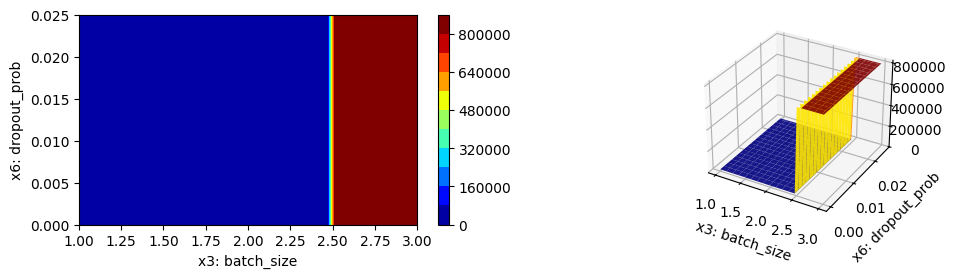

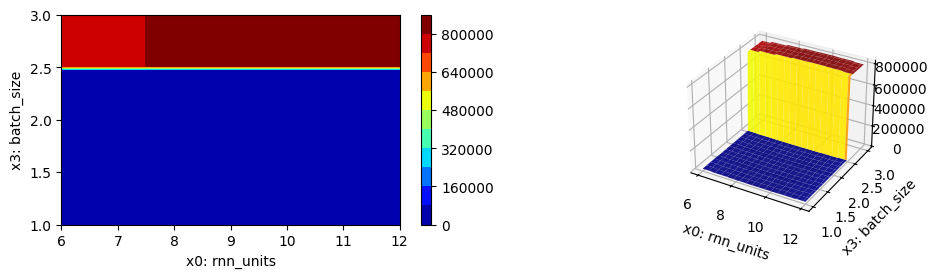

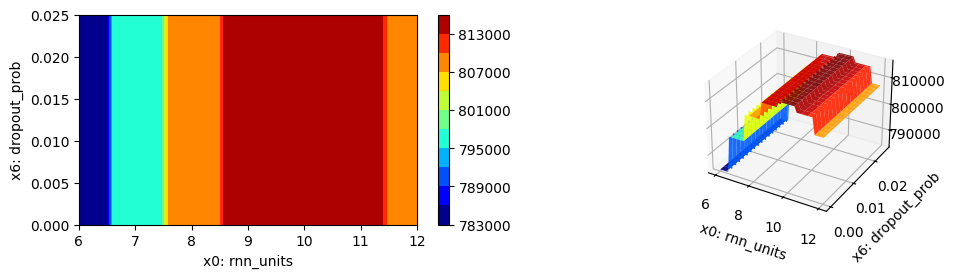

In [13]:
print_res_table(spot_tuner)
spot_tuner.plot_important_hyperparameter_contour(max_imp=3)

In [ ]:
len(spot_tuner.y)